In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 100)
plt.rcParams['figure.figsize'] = (9, 5)

os.makedirs('reports', exist_ok=True)
Data_Path = 'shipments.csv' 

In [4]:
# STEP 1 Load Data

df = pd.read_csv(Data_Path)

print('jumlah baris;', len(df))
print('\nKolom tersedia:')
print(df.columns.tolist())

print('\nInfo tipe data:')
print(df.info())

df.head(3)

jumlah baris; 5000

Kolom tersedia:
['shipment_id', 'booking_date', 'pickup_date', 'delivery_date', 'origin_hub', 'destination_city', 'service_type', 'distance_km', 'weight_kg', 'promised_sla_days', 'actual_transit_days', 'otd', 'first_attempt_success', 'attempted_deliveries', 'hub_dwell_hours', 'status', 'cost_idr', 'price_idr', 'contribution_idr']

Info tipe data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   shipment_id            5000 non-null   object 
 1   booking_date           5000 non-null   object 
 2   pickup_date            5000 non-null   object 
 3   delivery_date          5000 non-null   object 
 4   origin_hub             5000 non-null   object 
 5   destination_city       5000 non-null   object 
 6   service_type           5000 non-null   object 
 7   distance_km            5000 non-null   float64
 8  

,shipment_id,booking_date,pickup_date,delivery_date,origin_hub,destination_city,service_type,distance_km,weight_kg,promised_sla_days,actual_transit_days,otd,first_attempt_success,attempted_deliveries,hub_dwell_hours,status,cost_idr,price_idr,contribution_idr
0,SHP100000,2024-09-02,2024-09-02,2024-09-04,Pekanbaru,Semarang,YES,1491.5,1.43,1,2,False,True,1,33.8,Delivered,196711,304902,108191
1,SHP100001,2025-05-09,2025-05-09,2025-05-13,Denpasar,Semarang,REG,644.9,2.85,3,4,False,True,1,29.2,Delivered,96788,135503,38715
2,SHP100002,2025-03-27,2025-03-27,2025-04-02,Batam,Balikpapan,REG,1663.1,1.48,4,6,False,True,1,23.4,Delivered,213482,298874,85393


In [9]:
# STEP 2 Parse Dates & Derived Fields

import numpy as np
import pandas as pd 

df = pd.read_csv('shipments.csv')
df.head()
date_cols = ['booking_date', 'pickup_date', 'delivery_date']
for c in date_cols :
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors = 'coerce')
# make sure otd columns exist       
if 'otd' not in df.columns and {'actual_transit_days', 'promised_sla_days'}.issubset(df.columns):
    df['otd'] = df['actual_transit_days'] <= df['promised_sla_days']
# make sure other boolean columns consistenc
if 'first_attempt_success' in df.columns:
    df['first_attempt_success'] = df['first_attempt_success'].astype(bool)
# derived columns for agression
if 'pickup_date' in df.columns:
    df['month'] = df['pickup_date'].dt.to_period('M').astype(str)
    df['dow'] = df['pickup_date'].dt.day_name()
else:
    # fallback using booking_date
    df['month'] = df['booking_date'].dt.to_period('M').astype(str)
    df['dow'] = df['booking_date'].dt.day_name()
# Optional distance/weight comparison for segment analysis
if 'distance_km' in df.columns:
    bins = [0, 300, 1000, 2000, np.inf]
    labels = ['<=300', '301-1000', '1001-2000','>2000']
    df['distance_band'] = pd.cut(df['distance_km'], bins=bins, labels=labels, include_lowest=True)

    if 'weight_kg' in df.columns:
        wbins = [0, 1, 3, 10, np.inf]
        wlabels = ['<=1kg', '1-3kg', '3-10kg', '>10kg']
        df['weight_band'] = pd.cut(df['weight_kg'], bins=wbins, labels=wlabels, include_lowest=True)
        
df.head(3)


,shipment_id,booking_date,pickup_date,delivery_date,origin_hub,destination_city,service_type,distance_km,weight_kg,promised_sla_days,...,attempted_deliveries,hub_dwell_hours,status,cost_idr,price_idr,contribution_idr,month,dow,distance_band,weight_band
0,SHP100000,2024-09-02,2024-09-02,2024-09-04,Pekanbaru,Semarang,YES,1491.5,1.43,1,...,1,33.8,Delivered,196711,304902,108191,2024-09,Monday,1001-2000,1-3kg
1,SHP100001,2025-05-09,2025-05-09,2025-05-13,Denpasar,Semarang,REG,644.9,2.85,3,...,1,29.2,Delivered,96788,135503,38715,2025-05,Friday,301-1000,1-3kg
2,SHP100002,2025-03-27,2025-03-27,2025-04-02,Batam,Balikpapan,REG,1663.1,1.48,4,...,1,23.4,Delivered,213482,298874,85393,2025-03,Thursday,1001-2000,1-3kg


In [10]:
# STEP 3 Count KPI Top Level

import pandas as pd
df = pd.read_csv('shipments.csv')
df.head()

def kpi_table(_df: pd.DataFrame) -> pd.DataFrame:
    delivered_share = (_df['status'] == 'Delivered').mean() if 'status' in _df else np.nan
    otd_rate = _df['otd'].mean() if 'otd' in _df else np.nan
    fadr = _df['first_attempt_succes'].mean() if 'fisrt_attempt_succes' in _df else np.nan
    return_rate = (_df['status'] == 'Returned').mean() if 'status' in _df else np.nan
    avg_transit = _df['actual_transit_days'].mean() if 'actual_transit_transit' in _df else np.nan
    avg_dwell = _df['hub_dwell_hours'].mean() if 'hub_dwell_hours' in _df else np.nan
    revenue = _df['price_idr'].sum() if 'price_idr' in _df else np.nan
    cost = _df['cost_idr'].sum() if 'cost_idr' in _df else np.nan
    contrib = _df['contribution_idr'].sum() if 'contribution_idr' in _df else (revenue - cost if pd.notna(revenue) and pd.notna(cost) else np.nan)
    margin = contrib / revenue if (isinstance(contrib, (int,float)) and isinstance(revenue,(int,float)) and revenue) else np.nan

    return pd.DataFrame({
        'KPI': [
            'Deliveries (share)', 'On-Time Delivery Rate', 'First Attempt Delivery Rate',
            'Return Rate', 'Avg Transit Days', 'Avg Hub Dwell (hrs)', 
            'Revenue (IDR)', 'Cost (IDR)', 'Contribution (IDR)', 'Contribution Margin'
        ],
        'Value': [
            round(delivered_share, 4) if pd.notna(delivered_share) else None,
            round(otd_rate, 4) if pd.notna(otd_rate) else None,
            round(fadr, 4) if pd.notna(fadr) else None,
            round(return_rate, 4) if pd.notna(return_rate) else None,
            round(avg_transit, 2) if pd.notna(avg_transit) else None,
            round(avg_dwell, 1) if pd.notna(avg_dwell) else None,
            int(revenue) if pd.notna(revenue) else None,
            int(cost) if pd.notna(cost) else None,
            int(contrib) if pd.notna(contrib) else None,
            round(margin, 4) if pd.notna(margin) else None
        ]
    })
kpis = kpi_table(df)
kpis
    

,KPI,Value
0,Deliveries (share),9.598000e-01
1,On-Time Delivery Rate,4.554000e-01
2,First Attempt Delivery Rate,NaN
3,Return Rate,4.020000e-02
4,Avg Transit Days,NaN
5,Avg Hub Dwell (hrs),1.970000e+01
6,Revenue (IDR),1.158780e+09
7,Cost (IDR),8.207104e+08
8,Contribution (IDR),3.380701e+08
9,Contribution Margin,NaN


In [11]:
# STEP 4 Group by service_type

import pandas as pd
import numpy as np
df = pd.read_csv('shipments.csv')
df.head()

assert 'service_type' in df.columns, "Kolom 'service_type' tidak ditemukan"

by_service = df.groupby('service_type').agg(
    shipment=('shipment_id', 'count') if 'shipment_id' in df.columns else ('service_type', 'size'),
    otd=('otd', 'mean') if 'otd' in df.columns else ('service_type', 'size'),
    fadr=('first_attempt_succes', 'mean') if 'forst_attempt_succes' in df.columns else ('service_type', 'size'),
    avg_transit=('actual_transit_days', 'mean') if 'actual_transit_days' in df.columns else ('service_type', 'size'),
    return_rate=('status', lambda s: (s == 'Returned').mean()) if 'status' in df.columns else ('service_type', 'size'),
    avg_contrib=('contribution_idr', 'mean') if 'contribution_idr' in df.columns else ('service_type', 'size'),
).reset_index()

by_service.sort_values('otd', ascending = False)


,service_type,shipment,otd,fadr,avg_transit,return_rate,avg_contrib
0,OKE,982,0.463340,982,5.095723,0.039715,49173.059063
1,REG,2968,0.458558,2968,4.125000,0.040431,65661.001348
2,YES,1050,0.439048,1050,1.962857,0.040000,90381.201905


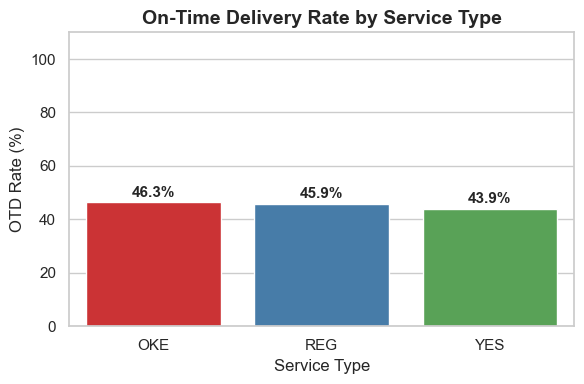

In [16]:
# Visual OTD by service

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('shipments.csv')
df.head()

# Counting OTD rate per service_type
otd_service = df.groupby('service_type')['otd'].mean().reset_index()
otd_service['otd_percent'] = otd_service['otd'] * 100

# Style seaborn
sns.set_theme(style="whitegrid", palette="Set1")

plt.figure(figsize=(6,4))
bar = sns.barplot(
    data=otd_service, 
    x='service_type', 
    y='otd_percent', 
    hue='service_type',
    dodge=False,
    legend=False
)

# Add number label above bar
for i, row in otd_service.iterrows():
    bar.text(i, row['otd_percent'] + 1, f"{row['otd_percent']:.1f}%", 
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Custom chart
plt.title("On-Time Delivery Rate by Service Type", fontsize=14, fontweight='bold')
plt.ylabel("OTD Rate (%)")
plt.xlabel("Service Type")
plt.ylim(0, 110)
plt.tight_layout()
plt.show()


In [18]:
# STEP 5 Group by origin_hub (to get know relation between low OTD and High dwell)

df = pd.read_csv('shipments.csv')
df.head()

assert 'origin_hub' in df.columns, "Kolom 'origin_hub' tidak ditemukan"

by_origin = df.groupby('origin_hub').agg(
    shipment=('shipment_id', 'count') if 'shipment_id' in df.columns else ('origin_hub', 'size'),
    otd=('otd', 'mean') if 'otd' in df.columns else ('origin_hub', 'size'),
    avg_dwell=('hub_dwell_hours', 'mean') if 'hub_dwell_hours' in df.columns else ('origin_hub', 'size'),
    avg_transit=('actual_transit_days', 'mean') if 'acrual_transit_days' in df.columns else ('origin_hub', 'size'),
).reset_index().sort_values(['otd', 'avg_dwell'], ascending=[True, False])

by_origin.head(10)


,origin_hub,shipment,otd,avg_dwell,avg_transit
8,Manado,299,0.381271,24.230435,299
9,Medan,304,0.401316,20.031579,304
5,Jakarta,300,0.416667,14.107667,300
3,Batam,329,0.437690,20.120365,329
11,Pekanbaru,310,0.445161,19.664839,310
4,Denpasar,332,0.451807,17.322892,332
2,Banjarmasin,294,0.452381,21.313265,294
13,Semarang,335,0.453731,18.389552,335
10,Palembang,341,0.460411,17.969795,341
6,Makassar,303,0.462046,21.610891,303


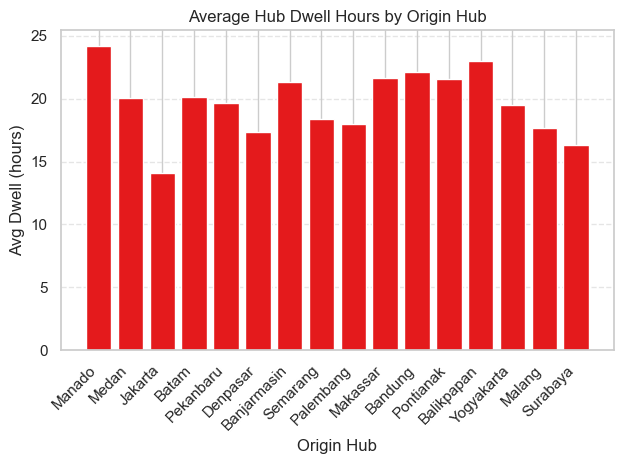

In [19]:
# Visual dwell by origin hub
import matplotlib.pyplot as plt

plt.figure()
plt.bar(by_origin["origin_hub"], by_origin["avg_dwell"])
plt.title("Average Hub Dwell Hours by Origin Hub")
plt.xlabel("Origin Hub")
plt.ylabel("Avg Dwell (hours)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("reports/dwell_by_origin.png", dpi=160)
plt.show()

In [20]:
# STEP 6 Route Level Performance (define baddest route)
df = pd.read_csv('shipments.csv')
df.head()

assert {"origin_hub","destination_city"}.issubset(df.columns), "Butuh kolom origin_hub & destination_city"

routes = df.groupby(["origin_hub", "destination_city"]).agg(
    shipments=("shipment_id", "count") if "shipment_id" in df.columns else ("origin_hub","size"),
    otd=("otd", "mean") if "otd" in df.columns else ("origin_hub","size"),
    avg_transit=("actual_transit_days", "mean") if "actual_transit_days" in df.columns else ("origin_hub","size"),
).reset_index()

worst_routes = routes[routes["shipments"] >= 30].sort_values(["otd","avg_transit"], ascending=[True, False]).head(10)
worst_routes

,origin_hub,destination_city,shipments,otd,avg_transit
137,Medan,Banjarmasin,31,0.290323,4.483871
228,Yogyakarta,Batam,30,0.500000,3.766667
183,Pontianak,Batam,31,0.516129,3.032258
49,Batam,Jakarta,30,0.533333,3.166667
217,Surabaya,Malang,30,0.533333,2.366667
61,Denpasar,Bandung,31,0.612903,3.161290
164,Palembang,Yogyakarta,32,0.625000,3.093750


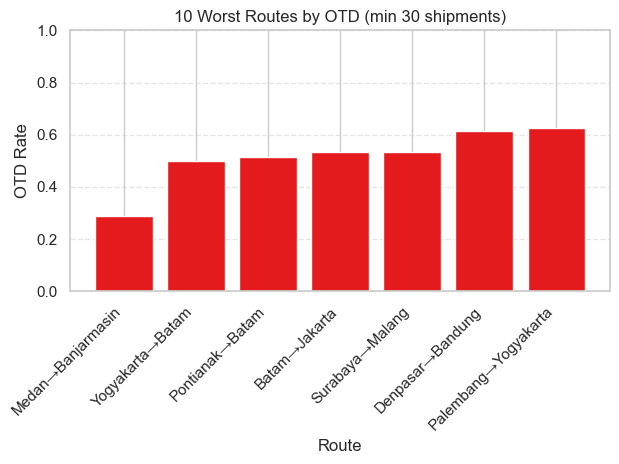

In [21]:
# Visual OTD Baddest Route
wr = worst_routes.copy()
wr["route"] = wr["origin_hub"] + "→" + wr["destination_city"]

plt.figure()
plt.bar(wr["route"], wr["otd"])
plt.title("10 Worst Routes by OTD (min 30 shipments)")
plt.xlabel("Route")
plt.ylabel("OTD Rate")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.savefig("reports/worst_routes_otd.png", dpi=160)
plt.show()

In [34]:
# Make Month Column before grouping

df = pd.read_csv('shipments.csv')
df.head()

if 'pickup_date' in df.columns:
    df['pickup_date'] = pd.to_datetime(df['pickup_date'], errors = 'coerce')
    df['month'] = df['pickup_date'].dt.to_period('M').astype(str)
else:
    df['booking_date']= pd.to_datetime(df['booking_date'], errors = 'coerce')
    df['month']= df['month_date'].dt.to_period('M').astype(str)  

print(df[['pickup_date', 'booking_date', 'month']].head())

  pickup_date booking_date    month
0  2024-09-02   2024-09-02  2024-09
1  2025-05-09   2025-05-09  2025-05
2  2025-03-27   2025-03-27  2025-03
3  2025-01-08   2025-01-07  2025-01
4  2025-01-05   2025-01-05  2025-01


In [35]:
# STEP 7 Volume vs OTD

monthly = df.groupby("month").agg(
    shipments=("shipment_id", "count") if "shipment_id" in df.columns else ("month","size"),
    otd=("otd", "mean") if "otd" in df.columns else ("month","size"),
).reset_index()

# Urutkan bulan secara kronologis jika string "YYYY-MM"
try:
    monthly["month_dt"] = pd.to_datetime(monthly["month"], format="%Y-%m")
    monthly = monthly.sort_values("month_dt")
except:
    pass

monthly.head()

,month,shipments,otd,month_dt
0,2024-08,394,0.423858,2024-08-01
1,2024-09,457,0.433260,2024-09-01
2,2024-10,421,0.470309,2024-10-01
3,2024-11,424,0.485849,2024-11-01
4,2024-12,415,0.438554,2024-12-01


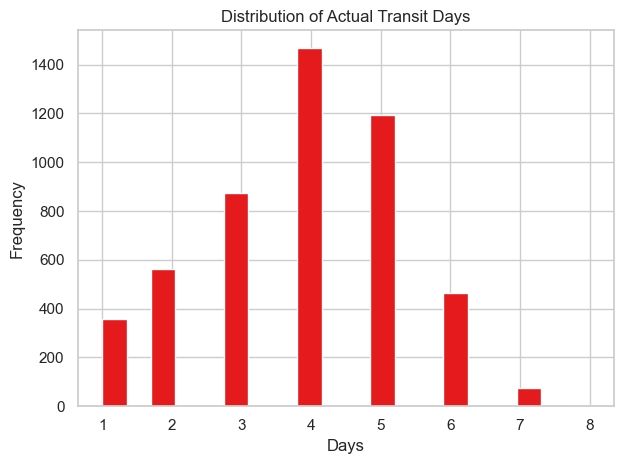

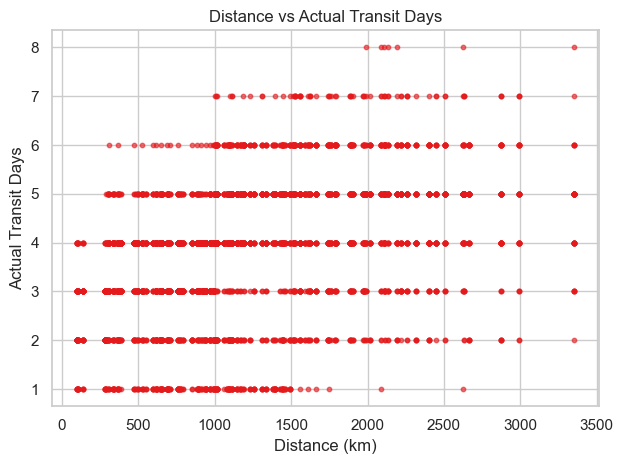

In [36]:
# STEP 8 Distribute & Relation matric operational (to get know transit pattern & distance)

if "actual_transit_days" in df.columns:
    plt.figure()
    plt.hist(df["actual_transit_days"].dropna(), bins=20)
    plt.title("Distribution of Actual Transit Days")
    plt.xlabel("Days")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.savefig("reports/dist_transit_days.png", dpi=160)
    plt.show()

if {"distance_km","actual_transit_days"}.issubset(df.columns):
    plt.figure()
    plt.scatter(df["distance_km"], df["actual_transit_days"], s=10, alpha=0.6)
    plt.title("Distance vs Actual Transit Days")
    plt.xlabel("Distance (km)")
    plt.ylabel("Actual Transit Days")
    plt.tight_layout()
    plt.savefig("reports/scatter_distance_transit.png", dpi=160)
    plt.show()
